In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

import tqdm

import importlib
sys.path.insert(0, '../')
import enhancer_gene_utils
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '../enhancer_gene_utils.py'>

In [2]:
today = datetime.date.today()
print(today)

2021-01-08


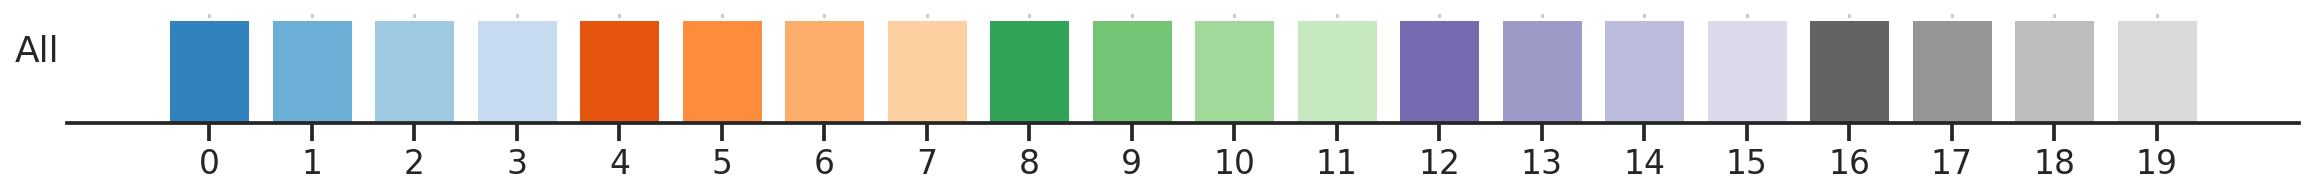

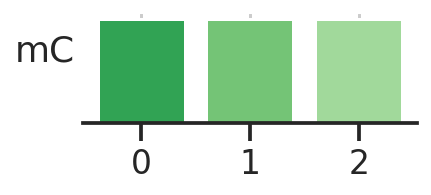

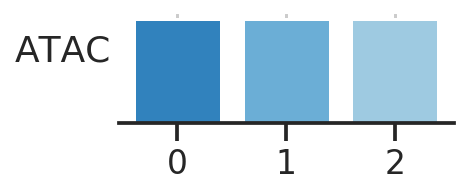

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


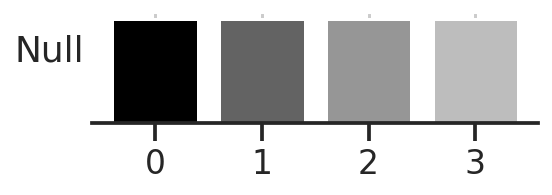

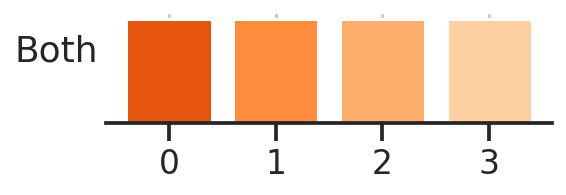

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]
colors_both = [cm[4], cm[5], cm[6], cm[7]]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
    colors_both,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
    'Both',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
# basic setup
color_palette = {
    'mc': colors_mc[0],
    'atac': colors_atac[0],
    'both': colors_both[1],
}

# read in the grand summary 
### - 80% cells for 5-time downsampling

In [5]:
output_figures = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_metacell_corr_res_{{}}.pdf'.format(today)
print(output_figures)

/cndd2/fangming/projects/scf_enhancers/results/figures/2021-01-08_metacell_corr_res_{}.pdf


In [6]:
input_summary = '/cndd2/fangming/projects/scf_enhancers/results/2020-01-08_metacell_corr_res_grand_res_summary_table.tsv.gz'
iterator_both = pd.read_csv(input_summary, sep='\t')
print(iterator_both.shape)
iterator_both.head()

FileNotFoundError: [Errno 2] No such file or directory: '/cndd2/fangming/projects/scf_enhancers/results/2020-01-08_metacell_corr_res_grand_res_summary_table.tsv.gz'

# Plot 1 knn

In [ ]:
def plot1(_table, _table_std, 
          mc_baseline, atac_baseline, both_baseline,
          fdr_threshold,
          title_label='',
          output='',
         ):
    """
    """
    plot_cols = [
        'num_linked_pairs',
        'num_linked_genes',
        'num_linked_enhs',

        'num_total_pairs',
        'num_total_genes',
        'num_total_enhs',
    ]
    
    fig, axs = plt.subplots(2, 3, figsize=(5*3, 4*2))
    fig.suptitle('mC/ATAC-RNA (10x_cells_v3) cell correlation analysis\n(k={}; FDR={}; {})'
                 .format(knn, fdr_threshold, title_label,), 
                 fontsize=15, y=1)
    for i_ax, (ax, col) in enumerate(zip(axs.flat, plot_cols)):
        ymax = 0
        for _suffix, _type in zip(['_mc', '_atac', '_both'], 
                                  ['mC-RNA', 'ATAC-RNA', 'both'],
                                 ):
            color = color_palette[_suffix.strip('_')]
            _x = _table['num_clst']
            _x_std = _table_std['num_clst']
            _y = _table[col+_suffix]
            _y_std = _table_std[col+_suffix] 

#             ax.errorbar(_x, _y, yerr=_y_std, xerr=_x_std.values, 
#                         fmt='-o', 
#                         markersize=5, 
#                         color=color,
#                         label=_type)

            ax.plot(_x, _y, '-o', markersize=3, label=_type, color=color)
            ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5, color=color)
            ymax = np.max([ymax, np.max(_y)])

        if i_ax == 0:
            ax.axhline(mc_baseline, color=color_palette['mc'], linestyle='--', alpha=0.5, label='mC-RNA (38 clusters)')
            ax.axhline(atac_baseline, color=color_palette['atac'], linestyle='--', alpha=0.5, label='ATAC-RNA (38 clusters)')
            ax.axhline(both_baseline, color=color_palette['both'], linestyle='--', alpha=0.5, label='both (38 clusters)')
            ymax = max(ymax, mc_baseline, atac_baseline, both_baseline)

        ax.set_xscale('log')
        ax.set_xlim([5, 20000])
        ax.set_xticks([10, 100, 1000, 10000])
        ax.set_ylim(ymin=0, ymax=1.1*ymax)
        ax.set_ylabel(col.replace('_', ' ')+(" +/- std"))

        ax.xaxis.set_major_formatter(mtick.EngFormatter())
        ax.yaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_xlabel('Num metacells')

    # axs[-1].axis('off') 
    handles, labels = axs.flat[0].get_legend_handles_labels()
    # handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    axs.flat[2].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    fig.subplots_adjust(wspace=0.4, hspace=0.3)
    if output:
        snmcseq_utils.savefig(fig, output)
    plt.show()

In [ ]:
knn = 30

iterator_toplot = iterator_both[iterator_both['k']==knn].sort_values(['r', 'i'])

# for a fixed k, groupby r (collapsing i)
res_mean = iterator_toplot.groupby(['r']).mean().reset_index()
res_std = iterator_toplot.groupby(['r']).std().reset_index().fillna(0)

fdr_threshold = 0.2
mc_baseline = 6094+1300
atac_baseline = 2700+1300
both_baseline = 1300
title_label = '80% cell downsampling for 5 times'

output = output_figures.format('p1_k{}'.format(knn))
print(output)
plot1(res_mean, res_std, 
      mc_baseline, atac_baseline, both_baseline,
      fdr_threshold,
      title_label=title_label,
      output=output,
     )
    

## Plot with different knn 

In [ ]:
knns = np.sort(iterator_both['k'].unique())
print(knns)

In [ ]:
for knn in knns:
    iterator_toplot = iterator_both[iterator_both['k']==knn].sort_values(['r', 'i'])

    # for a fixed k, groupby r (collapsing i)
    res_mean = iterator_toplot.groupby(['r']).mean().reset_index()
    res_std = iterator_toplot.groupby(['r']).std().reset_index().fillna(0)
     
    mc_baseline = 6094+1300
    atac_baseline = 2700+1300
    both_baseline = 1300

    output = output_figures.format('p1_k{}'.format(knn))
    print(output)
    plot1(res_mean, res_std, 
          mc_baseline, atac_baseline, both_baseline,
          fdr_threshold,
          output=output,
         )